### Required Packages: 
Numpy, Numba, Matplotlib and Pytorch

### Running this Notebook
Set the hyperparameters in cell [2]. Use this notebook to get all the parameters for plotting the frontier and the graphs

In [1]:
import os
import sys
import time
import logging
import argparse
import numpy as np

import torch
from torch import nn, optim
import torch.nn.functional as F

from data import Data
from net import Net

import baselines

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 16})

### Set the hyperparamters here. 
Make sure models corresponding to $\lambda, prob, corr$ are already trained.  
Models can be trained using one of these:
 - Notebook:        train_example.py
 - Commandline:
```
python train.py -n <num_agents> -l <lambda> -p <p_trunc> -c <p_corr>
```

In [2]:
class HParams:
    def __init__(self):
        self.num_agents = 4
        self.batch_size = 1024
        self.num_hidden_layers = 4
        self.num_hidden_nodes = 256
        self.num_val_batches = 200
        
        # Higher probability => More truncation
        self.prob = 0.2
        # Higher lambd => More stability
        self.lambd = -1
        # Correlation of rankings
        self.corr = 0.00
        # Run seed
        self.seed = 1
        
        
# Initialize config
cfg = HParams()
device = "cuda:0"
np.random.seed(cfg.seed)

# Set the points to plot.
lambdas = np.linspace(0, 1, 11)

#### Loss functions in PyTorch

In [ ]:
def torch_var(x): return torch.Tensor(x).to(device)

# Loss functions in pytorch
def compute_st(r, p, q):        
    wp = F.relu(p[:, :, None, :] - p[:, :, :, None])
    wq = F.relu(q[:, :, None, :] - q[:, None, :, :], 0)  
    t = (1 - torch.sum(r, dim = 1, keepdim = True))
    s = (1 - torch.sum(r, dim = 2, keepdim = True))
    rgt_1 = torch.einsum('bjc,bijc->bic', r, wq) + t * F.relu(q)
    rgt_2 = torch.einsum('bia,biac->bic', r, wp) + s * F.relu(p)
    regret =  rgt_1 * rgt_2 
    return regret.sum(-1).sum(-1).mean()/cfg.num_agents

def compute_ir(r, p, q):
    ir_1 = r * F.relu(-q)
    ir_2 = r * F.relu(-p)
    ir = ir_1 + ir_2
    return ir.sum(-1).sum(-1).mean()/cfg.num_agents

def compute_ic_FOSD(r, p, q, P, Q, r_mult = 1):
            
    IC_viol_P = torch.zeros(cfg.num_agents).to(device)
    IC_viol_Q = torch.zeros(cfg.num_agents).to(device)
    
    discount = torch_var((r_mult) ** np.arange(cfg.num_agents))

    for agent_idx in range(cfg.num_agents):

        P_mis, Q_mis = G.generate_all_misreports(P, Q, agent_idx = agent_idx, is_P = True, include_truncation = True)
        p_mis, q_mis = torch_var(P_mis), torch_var(Q_mis)
        r_mis = model(p_mis.view(-1, cfg.num_agents, cfg.num_agents), q_mis.view(-1, cfg.num_agents, cfg.num_agents))
        r_mis = r_mis.view(*P_mis.shape)

        r_diff = (r_mis[:, :, agent_idx, :] - r[:, None, agent_idx, :])*(p[:, None, agent_idx, :] > 0).float()
        _, idx = torch.sort(-p[:, agent_idx, :])
        idx = idx[:, None, :].repeat(1, r_mis.size(1), 1)
        
        fosd_viol = torch.cumsum(torch.gather(r_diff, -1, idx) * discount, -1)
        IC_viol_P[agent_idx] = F.relu(fosd_viol).max(-1)[0].max(-1)[0].mean(-1)

        P_mis, Q_mis = G.generate_all_misreports(P, Q, agent_idx = agent_idx, is_P = False, include_truncation = True)
        p_mis, q_mis = torch_var(P_mis), torch_var(Q_mis)
        r_mis = model(p_mis.view(-1, cfg.num_agents, cfg.num_agents), q_mis.view(-1, cfg.num_agents, cfg.num_agents))
        r_mis = r_mis.view(*Q_mis.shape)
        
        r_diff = (r_mis[:, :, :, agent_idx] - r[:, None, :, agent_idx])*(q[:, None, :, agent_idx] > 0).float()
        _, idx = torch.sort(-q[:, :, agent_idx])
        idx = idx[:, None, :].repeat(1, r_mis.size(1), 1)
        
        fosd_viol = torch.cumsum(torch.gather(r_diff, -1, idx) * discount, -1)
        IC_viol_Q[agent_idx] = F.relu(fosd_viol).max(-1)[0].max(-1)[0].mean(-1)

    IC_viol = (IC_viol_P.mean() + IC_viol_Q.mean())*0.5
    return IC_viol

#### Loss functions in Numpy

In [ ]:
# Loss functions numpy
def STABILITY_VIOLATION_BATCH(P, Q, R):
    WP = np.maximum(P[:, :, np.newaxis, :] - P[:, :, :, np.newaxis], 0)
    WQ = np.maximum(Q[:, :, np.newaxis, :] - Q[:, np.newaxis, :, :], 0)   
       
    T = (1 - np.sum(R, axis = 1, keepdims = True))
    S = (1 - np.sum(R, axis = 2, keepdims = True))
    
    RGT_1 = np.einsum('bjc,bijc->bic', R, WQ) + T * np.maximum(Q, 0)
    RGT_2 = np.einsum('bia,biac->bic', R, WP) + S * np.maximum(P, 0)
    
    REGRET =  RGT_1 * RGT_2 
    
    return REGRET.sum(-1).sum(-1).mean()/cfg.num_agents

def IR_VIOLATION_BATCH(P, Q, R):
    IR_1 = R * np.maximum(-Q, 0)
    IR_2 = R * np.maximum(-P, 0)
    IR = IR_1 + IR_2
    return IR.sum(-1).sum(-1).mean()/cfg.num_agents

def IC_FOSD_VIOLATION_BATCH(P, Q, R, mechanism, r_mult = 1.0):
    
    IC_viol_P = np.zeros(cfg.num_agents)
    IC_viol_Q = np.zeros(cfg.num_agents)
    
    discount = r_mult ** np.arange(cfg.num_agents)

    for agent_idx in range(cfg.num_agents):
        P_mis, Q_mis = G.generate_all_misreports(P, Q, agent_idx = agent_idx, is_P = True, include_truncation = True)
        R_mis = mechanism(P_mis.reshape(-1, cfg.num_agents, cfg.num_agents),
                                 Q_mis.reshape(-1, cfg.num_agents, cfg.num_agents))
        R_mis = R_mis.reshape(cfg.batch_size, -1, cfg.num_agents, cfg.num_agents)

        
        R_diff = (R_mis[:, :, agent_idx, :] - R[:, None, agent_idx, :])*(P[:, None, agent_idx, :] > 0)
        IDX = np.argsort(-P[:, agent_idx, :])
        IDX = np.tile(IDX[:, None, :], (1, R_mis.shape[1], 1))
        
        FOSD_viol = np.cumsum(np.take_along_axis(R_diff, IDX, axis=-1) * discount, -1)
        IC_viol_P[agent_idx] = np.maximum(FOSD_viol, 0).max(-1).max(-1).mean(-1)
        
        P_mis, Q_mis = G.generate_all_misreports(P, Q, agent_idx = agent_idx, is_P = False, include_truncation = True)
        R_mis = mechanism(P_mis.reshape(-1, cfg.num_agents, cfg.num_agents),
                                 Q_mis.reshape(-1, cfg.num_agents, cfg.num_agents))
        R_mis = R_mis.reshape(cfg.batch_size, -1, cfg.num_agents, cfg.num_agents)

        R_diff = (R_mis[:, :, :, agent_idx] - R[:, None, :, agent_idx])*(Q[:, None, :, agent_idx] > 0)
        IDX = np.argsort(-Q[:, :, agent_idx])
        IDX = np.tile(IDX[:, None, :], (1, R_mis.shape[1], 1))
        
        FOSD_viol = np.cumsum(np.take_along_axis(R_diff, IDX, axis=-1)*discount, -1)
        IC_viol_Q[agent_idx] = np.maximum(FOSD_viol, 0).max(-1).max(-1).mean(-1)
        
    IC_viol = (IC_viol_P.mean() + IC_viol_Q.mean())*0.5
    return IC_viol

In [ ]:
# Data
G = Data(cfg)

# Neural Network
model = Net(cfg)
model.to(device)

#### Compute the Stability and IC violations of neural network mechanism trained using different values of $\lambda$

In [ ]:
root_dir = os.path.join("experiments", "agents_%d"%(cfg.num_agents),"corr_%.2f"%(cfg.corr))
seed = 0

ST = np.zeros(len(lambdas))
IC = np.zeros(len(lambdas))

for il, lam in enumerate(lambdas):  
    model_path = os.path.join(root_dir, "MODEL_%d_lambd_%f_prob_%.2f_corr_%.2f"%(seed, lam, cfg.prob, cfg.corr))
    model.load_state_dict(torch.load(model_path))
    np.random.seed(cfg.seed)
    print("Lam: ", lam)
    with torch.no_grad():
        val_st_loss = 0.0
        val_ic_loss = 0.0
        for j in range(cfg.num_val_batches):
            P, Q = G.generate_batch_with_corr(cfg.batch_size)
            p, q = torch_var(P), torch_var(Q)
            r = model(p, q)
            st_loss = compute_st(r, p, q)
            ic_loss = compute_ic_FOSD(r, p, q, P, Q)
            val_st_loss += st_loss.item() 
            val_ic_loss += ic_loss.item()
        val_st_loss = val_st_loss/cfg.num_val_batches
        val_ic_loss = val_ic_loss/cfg.num_val_batches
        print("\t[ST-Loss]: %f, [IC-Loss]: %f"%(val_st_loss, val_ic_loss))
        IC[il] = val_ic_loss
        ST[il] = val_st_loss

#### Compute the Stability and IC violations of the worker-proposing and firm-proposing DA, TTC and RSD*

*The one-sided RSD mechanism achieves better stability. So we use it instead of the two sided version.
This satifies all the properties as that of RSD for both sides

In [ ]:
def compute_violations(mech):
    np.random.seed(cfg.seed)
    VAL_ST_LOSS = 0.0
    VAL_IC_LOSS = 0.0    

    for j in range(cfg.num_val_batches):
        P, Q = G.generate_batch(cfg.batch_size)
        R = mech(P, Q)

        ST_LOSS = STABILITY_VIOLATION_BATCH(P, Q, R) + IR_VIOLATION_BATCH(P, Q, R)
        IC_LOSS = IC_FOSD_VIOLATION_BATCH(P, Q, R, mech)
        VAL_ST_LOSS += ST_LOSS
        VAL_IC_LOSS += IC_LOSS

        print("[Batch]: %d, [ST-Loss]: %f, [IC-Loss]: %f"%(j, ST_LOSS, IC_LOSS))
        
    VAL_ST_LOSS = VAL_ST_LOSS/cfg.num_val_batches
    VAL_IC_LOSS = VAL_IC_LOSS/cfg.num_val_batches
    print("\t[ST-Loss]: %f, [IC-Loss]: %f"%(VAL_ST_LOSS, VAL_IC_LOSS))
    return VAL_ST_LOSS, VAL_IC_LOSS


mech = baselines.compute_DA_batch
s1, i1 = compute_violations(mech)
mech = baselines.compute_DA_batch_switch
s2, i2 = compute_violations(mech)
DA_ST, DA_IC = max(s1, s2), max(i1, i2)

mech = baselines.compute_TTC_batch
s1, i1 = compute_violations(mech)
mech = baselines.compute_TTC_batch_switch
s2, i2 = compute_violations(mech)
TTC_ST, TTC_IC = max(s1, s2), max(i1, i2)

mech = baselines.compute_one_RSD_batch
s1, i1 = compute_violations(mech)
mech = baselines.compute_one_RSD_batch
s2, i2 = compute_violations(mech)
RSD_ST, RSD_IC = max(s1, s2), max(i1, i2)

#### Compute Losses for convex combinations of mechainisms
Note that this is not linear (as our losses aren't linear)

In [ ]:
def STABILITY_VIOLATION_BATCH_COMBO(P, Q, mech_1, mech_2, lams):
    
    ST_VIOL = np.zeros(len(lams))
    R_1 = mech_1(P, Q)
    R_2 = mech_2(P, Q)
    for idx, lam in enumerate(lams):        
        R = lam * R_1 + (1 - lam) * R_2
        ST_VIOL[idx] = STABILITY_VIOLATION_BATCH(P, Q, R)
        
    return ST_VIOL

def IR_VIOLATION_BATCH_COMBO(P, Q, mech_1, mech_2, lams):
    IR_VIOL = np.zeros(len(lams))
    R_1 = mech_1(P, Q)
    R_2 = mech_2(P, Q)
    for idx, lam in enumerate(lams):        
        R = lam * R_1 + (1 - lam) * R_2
        IR_VIOL[idx] = IR_VIOLATION_BATCH(P, Q, R)
        
    return IR_VIOL


def IC_VIOLATION_BATCH_COMBO(P, Q, mech_1, mech_2, lams):
    
    
    R_1 = mech_1(P, Q)
    R_2 = mech_2(P, Q)
    
    IC_viol_P = np.zeros(len(lams))
    IC_viol_Q = np.zeros(len(lams))
    
    for agent_idx in range(cfg.num_agents):
        P_mis, Q_mis = G.generate_all_misreports(P, Q, agent_idx = agent_idx, is_P = True, include_truncation = True)
        
        R_mis_1 = mech_1(P_mis.reshape(-1, cfg.num_agents, cfg.num_agents),
                                 Q_mis.reshape(-1, cfg.num_agents, cfg.num_agents))
        R_mis_1 = R_mis_1.reshape(cfg.batch_size, -1, cfg.num_agents, cfg.num_agents)
        
        R_mis_2 = mech_2(P_mis.reshape(-1, cfg.num_agents, cfg.num_agents),
                                 Q_mis.reshape(-1, cfg.num_agents, cfg.num_agents))
        R_mis_2 = R_mis_2.reshape(cfg.batch_size, -1, cfg.num_agents, cfg.num_agents)

        
        for idx, lam in enumerate(lams):
            
            R = lam * R_1 + (1 - lam) * R_2
            R_mis = lam * R_mis_1 + (1 - lam) * R_mis_2
            
            R_diff = (R_mis[:, :, agent_idx, :] - R[:, None, agent_idx, :])*(P[:, None, agent_idx, :] > 0)
            IDX = np.argsort(-P[:, agent_idx, :])
            IDX = np.tile(IDX[:, None, :], (1, R_mis.shape[1], 1))
        
            FOSD_viol = np.cumsum(np.take_along_axis(R_diff, IDX, axis=-1), -1)
            IC_viol_P[idx]  += np.maximum(FOSD_viol, 0).max(-1).max(-1).mean(-1)
            
            
        P_mis, Q_mis = G.generate_all_misreports(P, Q, agent_idx = agent_idx, is_P = False, include_truncation = True)
        
        R_mis_1 = mech_1(P_mis.reshape(-1, cfg.num_agents, cfg.num_agents),
                                 Q_mis.reshape(-1, cfg.num_agents, cfg.num_agents))
        R_mis_1 = R_mis_1.reshape(cfg.batch_size, -1, cfg.num_agents, cfg.num_agents)
        
        R_mis_2 = mech_2(P_mis.reshape(-1, cfg.num_agents, cfg.num_agents),
                                 Q_mis.reshape(-1, cfg.num_agents, cfg.num_agents))
        R_mis_2 = R_mis_2.reshape(cfg.batch_size, -1, cfg.num_agents, cfg.num_agents)

        for idx, lam in enumerate(lams):
            R = lam * R_1 + (1 - lam) * R_2
            R_mis = lam * R_mis_1 + (1 - lam) * R_mis_2
            
            R_diff = (R_mis[:, :, :, agent_idx] - R[:, None, :, agent_idx])*(Q[:, None, :, agent_idx] > 0)
            IDX = np.argsort(-Q[:, :, agent_idx])
            IDX = np.tile(IDX[:, None, :], (1, R_mis.shape[1], 1))
        
            FOSD_viol = np.cumsum(np.take_along_axis(R_diff, IDX, axis=-1), -1)
            IC_viol_Q[idx] += np.maximum(FOSD_viol, 0).max(-1).max(-1).mean(-1)
        
    IC_viol = (IC_viol_P + IC_viol_Q)/(2*cfg.num_agents)
    return IC_viol

In [ ]:
def compute_combination_violations(mech_1, mech_2, lams):
    np.random.seed(cfg.seed)

    VAL_ST_LOSS = np.zeros(len(lams))
    VAL_IC_LOSS = np.zeros(len(lams))

    for j in range(cfg.num_val_batches):
        P, Q = G.generate_batch(cfg.batch_size)

        ST_LOSS = STABILITY_VIOLATION_BATCH_COMBO(P, Q, mech_1, mech_2, lams) + IR_VIOLATION_BATCH_COMBO(P, Q, mech_1, mech_2, lams)
        IC_LOSS = IC_VIOLATION_BATCH_COMBO(P, Q, mech_1, mech_2, lams)

        VAL_ST_LOSS += ST_LOSS
        VAL_IC_LOSS += IC_LOSS

    ST_arr = VAL_ST_LOSS/cfg.num_val_batches
    IC_arr = VAL_IC_LOSS/cfg.num_val_batches
    
    return ST_arr, IC_arr

lams = np.linspace(0, 1, 11)

# Choose whichever side performed better 
mech_1 = baselines.compute_one_RSD_batch # (or) baselines.compute_one_RSD_batch_switch
mech_2 = baselines.compute_TTC_batch # (or) baselines.compute_TTC_batch_switch
mech_3 = baselines.compute_DA_batch # (or baselines.compute_DA_batch_switch)
ST_1, IC_1 = compute_combination_violations(mech_1, mech_2, lams)
ST_2, IC_2 = compute_combination_violations(mech_2, mech_3, lams)

#### Compute the welfare, similarity to DA and Normalized Entropy of neural network mechanisms trained using different values of $\lambda$

In [ ]:
lams = np.linspace(0, 1, 11)
WF = np.zeros(len(lambdas))
SM = np.zeros(len(lambdas))
EN = np.zeros(len(lambdas))

def plogp(x): return - x * np.log2(np.maximum(x, 1e-8))

root_dir = os.path.join("experiments", "agents_%d"%(cfg.num_agents), "corr_%.2f"%(cfg.corr ))
seed = 0

for il, lam in enumerate(lambdas):  
    model_path = os.path.join(root_dir, "MODEL_%d_lambd_%f_prob_%.2f_corr_%.2f"%(seed, lam, cfg.prob, cfg.corr))
    model.load_state_dict(torch.load(model_path))
    np.random.seed(cfg.seed)
    print("Lam: ", lam)
    
    with torch.no_grad():
        wel = 0.0
        sim = 0.0
        simp = 0.0
        simq = 0.0
        ent = 0.0
        for j in range(cfg.num_val_batches):
            P, Q = G.generate_batch_with_corr(cfg.batch_size)
            p, q = torch_var(P), torch_var(Q)
            r = model(p, q)
            R = r.detach().cpu().numpy()
            wel += (P * R + Q * R).sum()/(cfg.batch_size * cfg.num_agents * 2)
            GS_P = baselines.compute_gsm_batch(P, Q)
            GS_Q = baselines.compute_gsw_batch(P, Q)          
            
            sim_P = 2*(GS_P * R).sum(-1).sum(-1) + ((1 - GS_P.sum(-1)) * (1 - R.sum(-1))).sum(-1) + ((1 - GS_P.sum(-2)) * (1 - R.sum(-2))).sum(-1)
            sim_Q = 2*(GS_Q * R).sum(-1).sum(-1) + ((1 - GS_Q.sum(-1)) * (1 - R.sum(-1))).sum(-1) + ((1 - GS_Q.sum(-2)) * (1 - R.sum(-2))).sum(-1)
            
            simp += sim_P.mean()/(2*cfg.num_agents)
            simq += sim_Q.mean()/(2*cfg.num_agents)
            H = plogp(R).sum(-1).sum(-1) + 0.5 * plogp(1 - R.sum(-1)).sum(-1) + 0.5 * plogp(1 - R.sum(-2)).sum(-1)
            ent += H.mean()/cfg.num_agents/-np.log2(1/(cfg.num_agents + 1))
        
        sim = np.maximum(simp, simq)
        sim = sim/cfg.num_val_batches
        wel = wel/cfg.num_val_batches
        ent = ent/cfg.num_val_batches
        print("[Welfare]: %f, [Sim]: %f, [EN]: %f"%(wel, sim, ent))
        WF[il] = wel
        SM[il] = sim
        EN[il] = ent

#### Compute the Welfare of the worker-proposing and firm-proposing DA, TTC and RSD*

In [ ]:
def compute_welfare(mech):
    np.random.seed(cfg.seed)
    VAL_WF = 0.0
    for j in range(cfg.num_val_batches):
        P, Q = G.generate_batch(cfg.batch_size)
        R = mech(P, Q)
        VAL_WF += (P*R + Q*R).sum()/(cfg.batch_size * cfg.num_agents * 2)
    VAL_WF = VAL_WF/cfg.num_val_batches
    print("\t[WF]: %f"%(VAL_WF))
    return VAL_WF

mech_1 = baselines.compute_one_RSD_batch
mech_2 = baselines.compute_TTC_batch
mech_3 = baselines.compute_DA_batch

RSD_WF = max(compute_welfare(baselines.compute_one_RSD_batch), compute_welfare(baselines.compute_one_RSD_batch_switch))
TTC_WF = max(compute_welfare(baselines.compute_TTC_batch), compute_welfare(baselines.compute_TTC_batch_switch))
DA_WF  = max(compute_welfare(baselines.compute_DA_batch), compute_welfare(baselines.compute_DA_batch_switch))

#### Load the values here as shown.
This is a sample for prob = 0.20, corr = 0.00

In [3]:
lambdas = (np.linspace(0,1,11))

RSD_ST = 0.082711
RSD_IC = 0.0

DA_ST = 0.0
DA_IC = 0.055107

TTC_ST =  0.022504
TTC_IC =  0.020703

ST = np.array([8.72940240e-01, 1.02907460e-01, 1.02900282e-01, 1.02901798e-01,
       4.14119080e-02, 1.94829054e-02, 9.68230900e-03, 5.13924916e-03,
       4.01918336e-03, 9.53526572e-04, 1.29530635e-04])

IC = np.array([1.76672125e-08, 1.04047922e-08, 1.74304387e-08, 1.69786563e-08,
       8.50095017e-03, 1.80544120e-02, 1.89612895e-02, 2.54116420e-02,
       2.98713568e-02, 4.51296178e-02, 6.66147325e-02])

ST_1 = np.array([0.02250366, 0.02788563, 0.03340955, 0.03907543, 0.04488327,
       0.05083306, 0.0569248 , 0.0631585 , 0.06953416, 0.07605178,
       0.08271134])

IC_1 = np.array([2.07031250e-02, 1.86328125e-02, 1.65625000e-02, 1.44921875e-02,
       1.24218750e-02, 1.03515625e-02, 8.28125000e-03, 6.21093750e-03,
       4.14062500e-03, 2.07031250e-03, 2.23325319e-17])

ST_2 = np.array([0.        , 0.00177158, 0.00364956, 0.00563394, 0.00772471,
       0.00992188, 0.01222544, 0.0146354 , 0.01715176, 0.01977451,
       0.02250366])

IC_2 = np.array([0.05510742, 0.05122168, 0.04733594, 0.0434502 , 0.03956445,
       0.03567871, 0.03268359, 0.02968848, 0.02669336, 0.02369824,
       0.02070312])

WF = np.array([0.08570209, 0.48238026, 0.48238782, 0.48238619, 0.55193785,
       0.58156549, 0.60006206, 0.61339577, 0.63400719, 0.6407062 ,
       0.64281173])

DA_WF = 0.6411
TTC_WF = 0.62488
RSD_WF = 0.5899

SM = np.array([0.17349346, 0.32239679, 0.32239986, 0.32239915, 0.44271798,
       0.53721314, 0.63751662, 0.73822421, 0.96744009, 0.94198232,
       0.93899476])

EN = np.array([0.23966699, 0.74537022, 0.74531987, 0.74533159, 0.66558514,
       0.58761214, 0.49628668, 0.39928189, 0.00434687, 0.00868243,
       0.00843276])

(-0.0016666666666666668, 0.062)

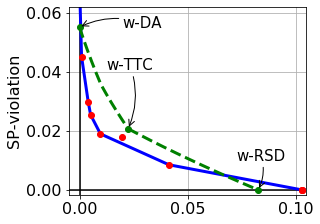

In [4]:
f,ax = plt.subplots(1,1, facecolor='w', figsize=(4, 3))
f.tight_layout(pad = 0.0)

idx = [0,1,2,3,4,6,7,8,9,10]

ax.grid()

ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')
ax.set_ylabel("SP-violation", fontsize=16)

ax.plot(ST[idx], IC[idx], linewidth = 3.0, color = "b")
ax.plot(ST, IC, "ro", markersize = 6.0)

ax.plot(ST_1, IC_1, linewidth = 3.0, color = "g", ls = "dashed")
ax.plot(ST_2, IC_2, linewidth = 3.0, color = "g", ls = "dashed")

ax.plot(DA_ST, DA_IC, "go", markersize = 6.0)
ax.plot(RSD_ST, RSD_IC, "go", markersize = 6.0)
ax.plot(TTC_ST, TTC_IC, "go", markersize = 6.0)

ax.annotate('w-DA',
            xy=(0.0, DA_IC), xycoords='data', fontsize = 15,
            xytext=(2e-2, DA_IC), textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))

ax.annotate('w-RSD',
            xy=(RSD_ST, 0.0), xycoords='data', fontsize = 15,
            xytext=(RSD_ST - 0.01, 0.01), textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-.2"))

ax.annotate('w-TTC',
            xy=(TTC_ST, TTC_IC), xycoords='data', fontsize = 15,
            xytext=(TTC_ST - 0.01, TTC_IC + 0.02), textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-.2"))

ax.set_xlim([-5e-3, 0.105])
ax.set_ylim([-5e-3/3, 0.062])

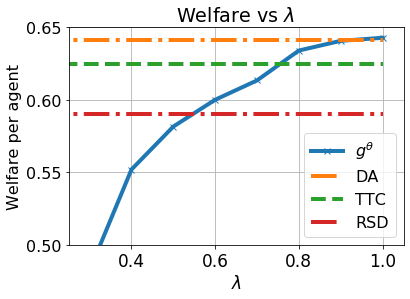

In [5]:
plt.plot(lambdas, WF, lw = 4.0, marker='x', label = r"$g^{\theta}$")
plt.grid()
plt.xlabel("$\lambda$", fontsize = 17)
plt.xticks(fontsize = 17)
plt.ylabel("Welfare per agent")
plt.plot([0, 1], [DA_WF, DA_WF], lw = 4.0,  ls = "dashdot", label = "DA")
plt.plot([0, 1], [TTC_WF, TTC_WF], lw = 4.0, ls = "dashed", label = "TTC")
plt.plot([0, 1], [RSD_WF, RSD_WF], lw = 4.0, ls = "dashdot", label = "RSD")

plt.legend()
plt.xlim([0.25, 1.05])
plt.ylim([0.5, 0.65])
_ = plt.title("Welfare vs $\lambda$")

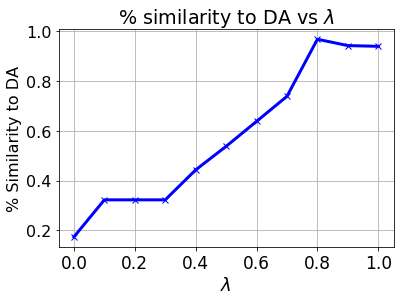

In [6]:
plt.plot(lambdas, SM, c = "b", lw = 3.0, marker='x', label = r"$Uncorrelated$")
plt.grid()
plt.xlabel("$\lambda$", fontsize = 18)
plt.xticks(fontsize = 17)
plt.ylabel("% Similarity to DA")
_ = plt.title("% similarity to DA vs $\lambda$")

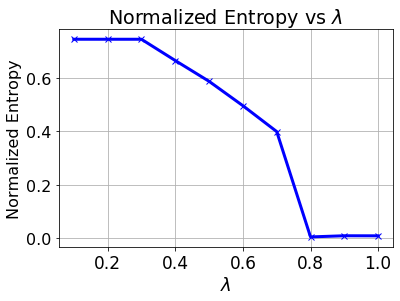

In [7]:
plt.plot(lambdas[1:], EN[1:], c = "b", lw = 3.0, marker='x', label = r"$Uncorrelated$")
plt.grid()
plt.xlabel("$\lambda$", fontsize = 18)
plt.xticks(fontsize = 17)
plt.ylabel("Normalized Entropy")
_ = plt.title("Normalized Entropy vs $\lambda$")